In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


In [5]:
# Path to dataset inside Drive
data_dir = "/content/drive/MyDrive/BUIS dataset/archive (6)/Dataset_BUSI_with_GT"

img_size = (224, 224)
batch_size = 32

# Train-validation split
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
print("✅ Classes found:", class_names)

# Optimize performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


Found 1578 files belonging to 3 classes.
Using 1263 files for training.
Found 1578 files belonging to 3 classes.
Using 315 files for validation.
✅ Classes found: ['benign', 'malignant', 'normal']


In [6]:
base_model = tf.keras.applications.MobileNetV3Small(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet",
    pooling="avg"
)

base_model.trainable = False  # Freeze base layers

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# --- Load MobileNetV3 base (no top layer) ---
base_model = MobileNetV3Small(weights="imagenet", include_top=False, input_shape=(224,224,3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
outputs = Dense(len(class_names), activation="softmax")(x)   # change num_classes to your dataset classes

model = Model(inputs=base_model.input, outputs=outputs)

# --- Compile ---
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy", # Changed loss function
              metrics=["accuracy"])

# --- Callbacks ---
earlystop_cb = EarlyStopping(monitor="val_loss",
                             patience=10,           # stop if no improvement for 10 epochs
                             restore_best_weights=True)

checkpoint_cb = ModelCheckpoint("mobilenetv3_best.h5",
                                save_best_only=True,
                                monitor="val_loss")

reduce_lr_cb = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)

# --- Train from epoch 1 ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1000000,        # huge number (effectively unlimited)
    callbacks=[earlystop_cb, checkpoint_cb, reduce_lr_cb],
    verbose=1
)

Epoch 1/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5758 - loss: 0.9075

40/40 ━━━━━━━━━━━━━━━━━━━━ 254s 5s/step - accuracy: 0.5789 - loss: 0.9027 - val_accuracy: 0.5968 - val_loss: 0.7618 - learning_rate: 1.0000e-04
Epoch 2/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8636 - loss: 0.3861

40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 245ms/step - accuracy: 0.8637 - loss: 0.3856 - val_accuracy: 0.6190 - val_loss: 0.6910 - learning_rate: 1.0000e-04
Epoch 3/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8987 - loss: 0.2757

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 216ms/step - accuracy: 0.8989 - loss: 0.2754 - val_accuracy: 0.6349 - val_loss: 0.6316 - learning_rate: 1.0000e-04
Epoch 4/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9388 - loss: 0.1869

40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 254ms/step - accuracy: 0.9389 - loss: 0.1867 - val_accuracy: 0.6349 - val_loss: 0.6253 - learning_rate: 1.0000e-04
Epoch 5/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 260ms/step - accuracy: 0.9521 - loss: 0.1346 - val_accuracy: 0.6317 - val_loss: 0.6308 - learning_rate: 1.0000e-04
Epoch 6/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.9737 - loss: 0.0978

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step - accuracy: 0.9738 - loss: 0.0977 - val_accuracy: 0.6603 - val_loss: 0.6222 - learning_rate: 1.0000e-04
Epoch 7/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 213ms/step - accuracy: 0.9879 - loss: 0.0581 - val_accuracy: 0.6508 - val_loss: 0.6332 - learning_rate: 1.0000e-04
Epoch 8/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 200ms/step - accuracy: 0.9846 - loss: 0.0540 - val_accuracy: 0.7714 - val_loss: 0.6590 - learning_rate: 1.0000e-04
Epoch 9/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 232ms/step - accuracy: 0.9867 - loss: 0.0549 - val_accuracy: 0.6571 - val_loss: 0.6582 - learning_rate: 1.0000e-04
Epoch 10/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 240ms/step - accuracy: 0.9890 - loss: 0.0378 - val_accuracy: 0.6603 - val_loss: 0.6249 - learning_rate: 1.0000e-04
Epoch 11/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9941 - loss: 0.0248

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 246ms/step - accuracy: 0.9941 - loss: 0.0248 - val_accuracy: 0.8000 - val_loss: 0.5710 - learning_rate: 1.0000e-04
Epoch 12/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - accuracy: 0.9899 - loss: 0.0301 - val_accuracy: 0.7873 - val_loss: 0.6005 - learning_rate: 1.0000e-04
Epoch 13/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - accuracy: 0.9947 - loss: 0.0233 - val_accuracy: 0.7968 - val_loss: 0.5834 - learning_rate: 1.0000e-04
Epoch 14/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 265ms/step - accuracy: 0.9957 - loss: 0.0145 - val_accuracy: 0.7841 - val_loss: 0.6348 - learning_rate: 1.0000e-04
Epoch 15/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 216ms/step - accuracy: 0.9960 - loss: 0.0183 - val_accuracy: 0.8032 - val_loss: 0.6059 - learning_rate: 1.0000e-04
Epoch 16/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9985 - loss: 0.0104
Epoch 16: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 227

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 250ms/step - accuracy: 0.9997 - loss: 0.0071 - val_accuracy: 0.8159 - val_loss: 0.5624 - learning_rate: 5.0000e-05
Epoch 21/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9982 - loss: 0.0094

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 274ms/step - accuracy: 0.9982 - loss: 0.0094 - val_accuracy: 0.8222 - val_loss: 0.5505 - learning_rate: 5.0000e-05
Epoch 22/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 227ms/step - accuracy: 0.9986 - loss: 0.0066 - val_accuracy: 0.8190 - val_loss: 0.5509 - learning_rate: 5.0000e-05
Epoch 23/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step - accuracy: 0.9996 - loss: 0.0040 - val_accuracy: 0.8095 - val_loss: 0.6012 - learning_rate: 5.0000e-05
Epoch 24/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.9989 - loss: 0.0063

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 250ms/step - accuracy: 0.9989 - loss: 0.0064 - val_accuracy: 0.8254 - val_loss: 0.5450 - learning_rate: 5.0000e-05
Epoch 25/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9983 - loss: 0.0072

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 249ms/step - accuracy: 0.9983 - loss: 0.0073 - val_accuracy: 0.8476 - val_loss: 0.4946 - learning_rate: 5.0000e-05
Epoch 26/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 235ms/step - accuracy: 0.9993 - loss: 0.0055 - val_accuracy: 0.8381 - val_loss: 0.5211 - learning_rate: 5.0000e-05
Epoch 27/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 214ms/step - accuracy: 0.9985 - loss: 0.0056 - val_accuracy: 0.8317 - val_loss: 0.5609 - learning_rate: 5.0000e-05
Epoch 28/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 262ms/step - accuracy: 0.9997 - loss: 0.0031 - val_accuracy: 0.8317 - val_loss: 0.5548 - learning_rate: 5.0000e-05
Epoch 29/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 263ms/step - accuracy: 0.9978 - loss: 0.0062 - val_accuracy: 0.8254 - val_loss: 0.5726 - learning_rate: 5.0000e-05
Epoch 30/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9996 - loss: 0.0039
Epoch 30: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 201m

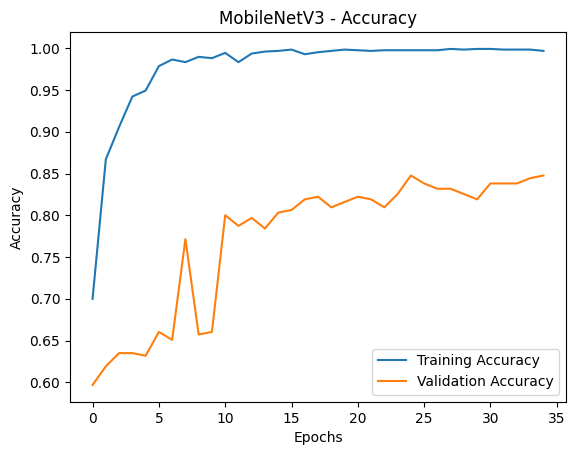

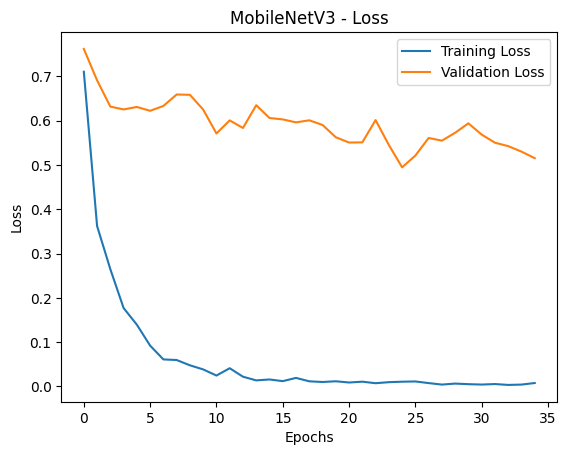

In [8]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("MobileNetV3 - Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("MobileNetV3 - Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 585ms/step


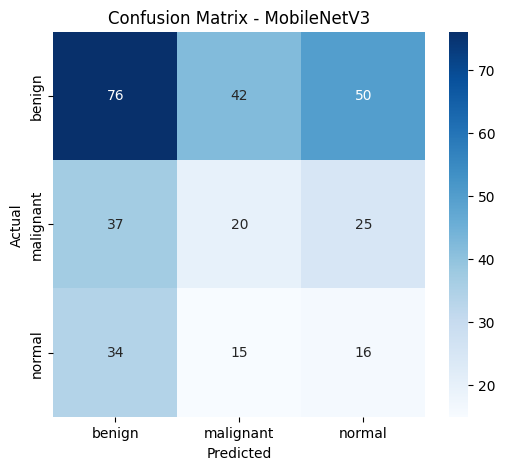

Classification Report:

              precision    recall  f1-score   support

      benign       0.52      0.45      0.48       168
   malignant       0.26      0.24      0.25        82
      normal       0.18      0.25      0.21        65

    accuracy                           0.36       315
   macro avg       0.32      0.31      0.31       315
weighted avg       0.38      0.36      0.37       315



In [9]:
# Get predictions
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - MobileNetV3")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step


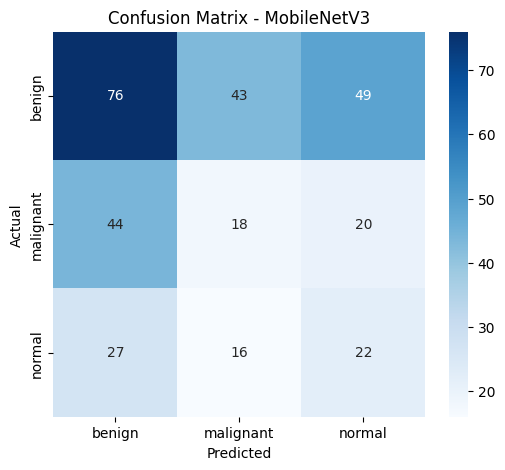

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get true labels and predictions
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - MobileNetV3")
plt.show()


In [11]:
# Save MobileNetV3 model in .h5 format
model.save("/content/drive/MyDrive/mobilenetv3_model.h5")
print("MobileNetV3 model saved successfully!")

MobileNetV3 model saved successfully!


In [13]:
# Evaluate MobileNetV3 model
loss, accuracy = model.evaluate(val_ds, verbose=1)
print(f"MobileNetV3 Test Accuracy: {accuracy * 100:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.8553 - loss: 0.4913
MobileNetV3 Test Accuracy: 84.76%
